In [1]:
#| default_exp BaltNet
#| default_cls_lvl 3

In [2]:
#| export

import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

import xarray as xr
from glob import glob
from tqdm import tqdm

from BalticRiverPrediction.convLSTM import ConvLSTM
from BalticRiverPrediction.sharedUtilities import read_netcdfs, preprocess, plot_loss_and_acc

In [3]:
#| export
class BaltNet(nn.Module):
    def __init__(self, modelPar):
        super(BaltNet, self).__init__()

        # initialize all attributes
        for k, v in modelPar.items():
            setattr(self, k, v)

        self.linear_dim = self.dimensions[0]*self.dimensions[1]*self.hidden_dim

        self.convLSTM = ConvLSTM(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                kernel_size=self.kernel_size,
                num_layers=self.num_layers,
                batch_first=self.batch_first,
                bias=self.bias,
                return_all_layers=self.return_all_layers
        )

        self.convLSTM2 = ConvLSTM(
                input_dim=self.input_dim,
                hidden_dim=self.hidden_dim,
                kernel_size=self.kernel_size,
                num_layers=1,
                batch_first=self.batch_first,
                bias=self.bias,
                return_all_layers=self.return_all_layers
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.linear_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
            )

    def forward(self, x):
        _, encode_state = self.convLSTM(x)
        decoder_out, _ = self.convLSTM2(x[:,-1:,:,:,:], encode_state)
        x = decoder_out[0]
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x).squeeze()
        return x


In [4]:
#| export
class BaseLineModel(nn.Module):
    def __init__(self, modelPar):
        super(BaseLineModel, self).__init__()

        # initialize all attributes
        for k, v in modelPar.items():
            setattr(self, k, v)

        self.linear_dim = self.dimensions[0]*self.dimensions[1]*self.hidden_dim*self.input_dim

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.linear_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
            )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x).squeeze()
        return x

In [5]:
#| export

from typing import Any


class LighningModel(L.LightningModule):
    def __init__(self, model, learning_rate, cosine_t_max):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.cosine_t_max = cosine_t_max

        self.save_hyperparameters(ignore=["model"])

        self.train_mse = torchmetrics.MeanSquaredError()
        self.val_mse = torchmetrics.MeanSquaredError()
        self.test_mse = torchmetrics.MeanSquaredError()

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, debug=False):
        features, true_labels = batch
        logits = self.model(features)
        loss = F.mse_loss(logits, true_labels)
        if debug == True:
            print(loss)
        return loss, true_labels, logits
    
    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, debug=False)
        mse = self.train_mse(predicted_labels, true_labels)
        metrics = {"train_mse":mse, "train_loss":loss}
        self.log_dict(metrics, on_step=True, on_epoch=True, prog_bar=True,logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, true_labes, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, sync_dist=True)
        self.val_mse(predicted_labels, true_labes)
        self.log(
            "val_mse", self.val_mse, prog_bar=True, sync_dist=True
        )
    
    def test_step(self, batch, _):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_mse(predicted_labels, true_labels)
        self.log("test_loss", loss, rank_zero_only=True)
        self.log("test_mse", self.test_mse, sync_dist=True)
        return loss
    
    def predict_step(self, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> Any:
        _, _, predicted_labels = self._shared_step(batch)
        return predicted_labels

    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=self.cosine_t_max)

        return [opt], [sch]


In [6]:
#| export
class AtmosphericDataset(Dataset):
    def __init__(self, datapath, transform=None):

        data = read_netcdfs(
            files=f"{datapath}/atmosphericForcing/????/rain.mom.dta.nc",
            dim="time",
            transform_func=lambda ds:preprocess(ds)
            )       
        labels = xr.open_mfdataset(f"{datapath}/runoffData/combined_fastriver_001.nc")
        runoff = labels.roflux.resample(time="1D").mean()

        rainData = data["RAIN"]
        runoffData = runoff.sel(time=slice(str(rainData.time.min().data), str(rainData.time.max().data)))
        X = (rainData - rainData.mean())/rainData.std()
        y = (runoffData - runoffData.mean())/runoffData.std()

        # TODO 
        # add dummy dimension in only one atmospheric data file
        # is loaded
        X = torch.tensor(X.compute().data, dtype=torch.float32)
        X = X.unsqueeze(dim=0)
        
        self.x = X
        self.y = torch.tensor(y.compute().data, dtype=torch.float32).flatten()

    def __getitem__(self, index):
        return self.x[:, index:index+30], self.y[index+30]

    def __len__(self):
        return self.y.shape[0]-30


In [7]:
#| export
class AtmosphereDataModule(L.LightningDataModule):
    def __init__(self, datapath, batch_size=64, num_workers=8, add_first_dim=True):
        super().__init__()
        self.data_dir = datapath
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.add_first_dim = add_first_dim

    def setup(self, stage:str):
        UserWarning("Loading atmospheric data ...")
        dataset = AtmosphericDataset(datapath=self.data_dir)
        n_samples = len(dataset)
        train_size = int(0.8 * n_samples)
        val_size = int(0.1 * n_samples)
        test_size = n_samples - train_size - val_size
        self.train, self.val, self.test = random_split(dataset, [train_size, val_size, test_size])

        
    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True, 
            drop_last=True, 
            num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(
            dataset=self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=True)

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers, 
            drop_last=True)

In [8]:
# Our GPU has tensor cores, hence mixed precision training is enabled
# see https://sebastianraschka.com/blog/2023/llm-mixed-precision-copy.html
# for more

torch.set_float32_matmul_precision("medium")

In [9]:
L.pytorch.seed_everything(123)

Global seed set to 123


123

Quickly inspect if $\Delta t$ in the data changes. If not simply resampling should do it.

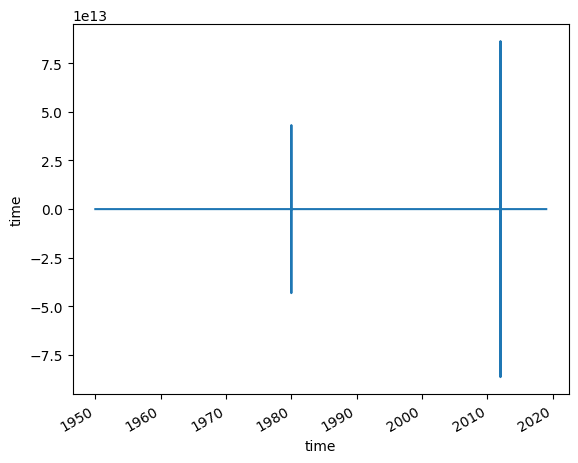

In [10]:
datapath = "/silor/boergel/paper/runoff_prediction/data"
labels = xr.open_mfdataset(f"{datapath}/runoffData/combined_fastriver_005.nc")
labels.time.diff("time").diff("time").plot()


In [11]:
dataLoader = AtmosphereDataModule(
    datapath="/silor/boergel/paper/runoff_prediction/data",
    batch_size=64
    )

In [12]:
modelParameters = {
    "input_dim":30, # timesteps
    "hidden_dim":1, # Channels -> right now only precipitation
    "kernel_size":(3,3), # applied for spatial convolutions
    "num_layers":2, # number of convLSTM layers
    "batch_first":True, # first index is batch
    "bias":True, 
    "return_all_layers": False, 
    "dimensions": (191, 206) # dimensions of atmospheric forcing
}

num_epochs = 50

In [13]:
pyTorchBaltNet = BaltNet(modelPar=modelParameters)
LighningBaltNet = LighningModel(pyTorchBaltNet, learning_rate=1e-3, cosine_t_max=num_epochs)

In [14]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_mse", save_last=True)
]

In [15]:
trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="cuda",
    devices=2,
    logger=CSVLogger(save_dir="/silor/boergel/paper/runoff_prediction/logs", name="BaltNet1"),
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model=LighningBaltNet, datamodule=dataLoader)

[rank: 0] Global seed set to 123
[rank: 1] Global seed set to 123
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

100%|██████████| 54/54 [01:52<00:00,  2.08s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | BaltNet          | 10.1 M
1 | train_mse | MeanSquaredError | 0     
2 | val_mse   | MeanSquaredError | 0     
3 | test_mse  | MeanSquaredError | 0     
-----------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params
40.302    

Epoch 0: 100%|██████████| 123/123 [00:16<00:00,  7.24it/s, v_num=43, train_mse_step=0.261, train_loss_step=0.261, val_mse=0.427]

/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_mse', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Epoch 9:  14%|█▍        | 17/123 [00:02<00:16,  6.44it/s, v_num=43, train_mse_step=0.0246, train_loss_step=0.0246, val_mse=0.0681, train_mse_epoch=0.0391, train_loss_epoch=0.0391] 

/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Epoch 10:  63%|██████▎   | 77/123 [00:09<00:05,  8.07it/s, v_num=43, train_mse_step=0.0607, train_loss_step=0.0607, val_mse=0.0531, train_mse_epoch=0.030, train_loss_epoch=0.030]  

In [ ]:
trainer.test(model=LighningBaltNet, datamodule=dataLoader)

[rank: 0] Global seed set to 123
[rank: 1] Global seed set to 123
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

100%|██████████| 54/54 [01:31<00:00,  1.69s/it]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:226: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Testing DataLoader 0: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4748583436012268     │
│         test_mse          │    0.4527163803577423     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4748583436012268, 'test_mse': 0.4527163803577423}]